# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [25]:
import pandas as pd
import os
from os.path import isfile, join
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms


BASE = "./Dataset"
#BASE = "gdrive/MyDrive/Dataset"
cloth_folder = os.path.join(BASE, "Cloth Mask")
n95_folder = os.path.join(BASE, "N95")
n95valve_folder = os.path.join(BASE, "N95 mask with valve")
surgical_folder = os.path.join(BASE, "Surgical Mask")
without_mask_folder = os.path.join(BASE, "No Mask")
root_folder = ("./")



In [26]:
# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(root_folder, 'model/AI.pth')
make_dir(model_path)

# predefined classes
classes = {
    "cloth": 0,
    "n95": 1,
    "n95valve": 2,
    "surgical": 3,
    "without_mask": 4
}


In [27]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, images, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        self.dataset = images[int(indexes[0]):int(indexes[1])]
        
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']



In [28]:

def load_images():
  dat = []
  cnt = 0   
  for filename in os.listdir(cloth_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(cloth_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['cloth']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(n95_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['n95']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(n95valve_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95valve_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['n95valve']
        dat.append(sample)
        cnt += 1
    except:
        continue

  for filename in os.listdir(surgical_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(surgical_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['surgical']
        dat.append(sample)
    except:
        continue

  for filename in os.listdir(without_mask_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(without_mask_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['without_mask']
        dat.append(sample)
    except:
        continue

  return dat



In [29]:

train_split_percentage = 0.75
test_split_percentage = 0.25

#load images into memory
images = load_images()
random.shuffle(images)
size_of_the_dataset = len(images)
print("size_of_the_dataset", size_of_the_dataset)


batch_size = 25
num_of_classes = len(classes.keys())


train_indexes = [0, train_split_percentage * size_of_the_dataset]
test_indexes = [train_split_percentage * size_of_the_dataset, size_of_the_dataset]


print(f"Effective train split = {train_indexes[0]} to {train_indexes[1]}")
print(f"Effective test split = {test_indexes[0]} to {test_indexes[1]}")


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


size_of_the_dataset 2065
Effective train split = 0 to 1548.75
Effective test split = 1548.75 to 2065


In [30]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])

In [31]:

print("Loading training set")
train_dataset = FaceMaskDataset(images, train_indexes, conversion=transform)

print("Train Dataset length ", len(train_dataset))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Loading training set
Train Dataset length  1548


In [32]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [33]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}".format(epoch+1, result['train_loss']))

In [34]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_of_classes),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [35]:

def fit(epochs, lr, model, train_loader, opt_func = torch.optim.SGD):
    
    results = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        results.append(result)
    
    return results

In [36]:

model = CNN()

In [37]:
torch.cuda.empty_cache()

In [38]:
results = fit(20, 0.01, model, train_loader, torch.optim.ASGD)


Epoch [1], train_loss: 1.5007
Epoch [2], train_loss: 1.1537
Epoch [3], train_loss: 0.9928
Epoch [4], train_loss: 0.7775
Epoch [5], train_loss: 0.5821
Epoch [6], train_loss: 0.4672
Epoch [7], train_loss: 0.1921
Epoch [8], train_loss: 0.1070
Epoch [9], train_loss: 0.0448
Epoch [10], train_loss: 0.0151
Epoch [11], train_loss: 0.0074
Epoch [12], train_loss: 0.0046
Epoch [13], train_loss: 0.0042
Epoch [14], train_loss: 0.0033
Epoch [15], train_loss: 0.0027
Epoch [16], train_loss: 0.0025
Epoch [17], train_loss: 0.0025
Epoch [18], train_loss: 0.0018
Epoch [19], train_loss: 0.0016
Epoch [20], train_loss: 0.0015


In [40]:
torch.save(model.state_dict(), os.path.join(model_path,"model.pth"))

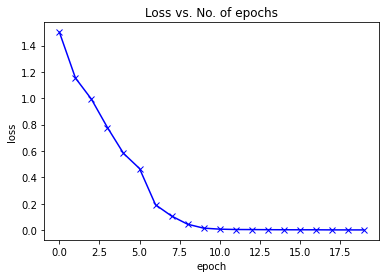

In [39]:
import matplotlib.pyplot as plt
def plot_losses(results):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in results]
    plt.plot(train_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

plot_losses(results)


In [41]:
test_dataset = FaceMaskDataset(images, test_indexes, conversion=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [42]:
y_true = torch.tensor([])
y_preds = torch.tensor([])

# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        y_true = torch.cat((y_true, labels))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_preds = torch.cat((y_preds, predicted))
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


Test Accuracy of the model: 60.154738878143135 %


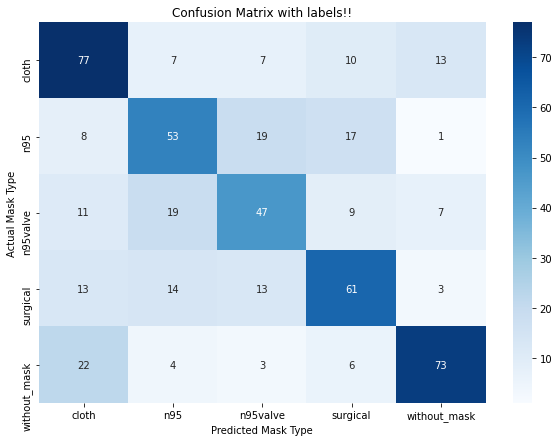

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# show confusion matrix
def show_confusion_matrix(y_true, y_preds):
    matrix = confusion_matrix(y_true, y_preds)
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels!!');
    ax.set_xlabel('Predicted Mask Type')
    ax.set_ylabel('Actual Mask Type')
    ax.xaxis.set_ticklabels([i for i in classes.keys()])
    ax.yaxis.set_ticklabels([i for i in classes.keys()])
    plt.show()

show_confusion_matrix(y_true, y_preds)


In [44]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_true, y_preds)
print(classification_report(y_true,y_preds))

              precision    recall  f1-score   support

         0.0       0.59      0.68      0.63       114
         1.0       0.55      0.54      0.54        98
         2.0       0.53      0.51      0.52        93
         3.0       0.59      0.59      0.59       104
         4.0       0.75      0.68      0.71       108

    accuracy                           0.60       517
   macro avg       0.60      0.60      0.60       517
weighted avg       0.60      0.60      0.60       517

